# **Impacto no uso de People Analytics em decisões organizacionais para identificação de talentos**

**Objetivo:** Este notebook objetiva apresentar os experimentos para a criação de um **Modelo de Classificação**, vinculado ao Trabalho de Conclusão de Curso para Data Science and Analytics, junto a USP-Esalq, utilizando a metodologia CRISP-DM, desde sua fase de Entendimento dos Dados à última etapa de Implantação. 

**Experimentos**: As testagens considerarão o uso de três modelagens: Regressão Logística, Árvore de Decisão e Random Forest. As escolhas destes algoritmos se deram justamente pela complementação entre eles, além da facilidade de uso e interpretabilidade dos modelos. A Regressão Logística é fácil de interpretar e mostra como cada variável impacta a chance de promoção. A Árvore de Decisão gera regras simples e visuais que facilitam entender as decisões. Já o Random Forest é mais robusto, melhorando a precisão e ajudando a evitar erros comuns em modelos mais simples. Desta forma, se torna possível analisar e comparar de forma clara a performance de cada um deles, auxiliando na escolha do modelo "vencedor".

**Link Dataset:** https://www.kaggle.com/datasets/bhrt97/hr-analytics-classification

*Para acessar a documentação do projeto, com os insights, instruções e resultados obtidos, acesse o arquivo README.md deste repositório*

## 📘 Dicionário de Variáveis

| Nome da Variável       | Significado                                                                                           |
|------------------------|-------------------------------------------------------------------------------------------------------|
| **matricula**          | Identificador único do(a) colaborador(a) na empresa.                                                  |
| **departamento**       | Departamento ou área em que o(a) colaborador(a) atua (ex: Vendas, Tecnologia, RH).                   |
| **regiao**             | Região geográfica de atuação do(a) colaborador(a) (sem ordem ou hierarquia específica).               |
| **escolaridade**       | Nível educacional alcançado pelo(a) colaborador(a) (ex: Graduação, Pós-graduação, etc.).             |
| **genero**             | Gênero do(a) colaborador(a), geralmente categorizado como "Masculino" ou "Feminino".                 |
| **canal_recrutamento** | Canal através do qual o(a) colaborador(a) foi recrutado(a) (ex: Recrutamento Interno, Agência).      |
| **qtd_treinamentos**   | Número de treinamentos (técnicos ou comportamentais) realizados no ano anterior.                      |
| **idade**              | Idade do(a) colaborador(a), em anos.                                                                  |
| **avaliacao_anterior** | Nota de desempenho atribuída ao(à) colaborador(a) no ano anterior (geralmente em uma escala de 1 a 5).|
| **tempo_empresa**      | Tempo de serviço na empresa, em anos completos.                                                       |
| **kpis_atingidos**     | Indicador binário: 1 se mais de 80% dos KPIs (indicadores de performance) foram atingidos; 0 caso contrário. |
| **premios**            | Indicador binário: 1 se o(a) colaborador(a) ganhou algum prêmio no ano anterior; 0 caso contrário.    |
| **media_treinamento**  | Nota média obtida nos treinamentos atuais (avaliações de desempenho nos cursos realizados).           |
| **promovido**          | Variável alvo (target): 1 se o(a) colaborador(a) foi recomendado(a) para promoção; 0 caso contrário.  |


## Importar Bibliotecas

In [1]:
# ============================================================
# 1. Importação de bibliotecas para manipulação dos dados e plots 
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from modulo_graficos import grafico_movimentacao_promovidos  # Função customizada do projeto
import seaborn as sns
from scipy.stats import chi2_contingency

# ============================================================
# 2. Importação de bibliotecas relacionadas à machine learning
# ============================================================

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
)
from sklearn.metrics import (
    make_scorer, precision_score, f1_score, roc_auc_score, roc_curve,
    recall_score, fbeta_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, precision_recall_curve, auc
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
import optuna

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import joblib  # Para salvar e carregar modelos

In [2]:
# ============================================================
# 3. Ajustes visuais para exibição das tabelas
# ============================================================

pd.set_option('display.max_colwidth', None)     # Exibe o conteúdo completo das colunas
pd.set_option('display.max_rows', None)         # Exibe todas as linhas da tabela
pd.set_option('display.max_columns', None)      # Exibe todas as colunas da tabela
pd.set_option('display.float_format', '{:.2f}'.format)  # Exibe números decimais com 2 casas

## Input dos Dados

A base de dados disponibilizada pelo Kaggle está dividida em dois arquivos: treino e teste. 

Seguirei, portanto, a seguinte abordagem:

- A base de treino será utilizada para treinamento e validação do modelo (usando técnicas como validação cruzada ou divisão em treino/validação).
- A base de teste será utilizada apenas posteriormente para geração das previsões finais, pois seus rótulos são ocultos (avaliação cega).

A abordagem segue desta forma, pois visa garantir que o modelo não tenha acesso a dados do conjunto de teste durante o treinamento, evitando vazamento de informação e garantindo uma avaliação justa.

In [3]:
# ============================================================
# 4. Carrego os dados e verifico suas dimensões iniciais
# ============================================================

df_treino = pd.read_csv("dataset/train_hr_class.csv")
df_teste = pd.read_csv("dataset/test_hr_class.csv")  # Base sem target, usada apenas para validação

print(f"DF Treino: {df_treino.shape}")
print(f"DF Teste: {df_teste.shape}")

DF Treino: (54808, 14)
DF Teste: (23490, 13)


In [4]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [5]:
df_treino.head(1)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.00,8,1,0,49,0


In [6]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           23490 non-null  int64  
 1   department            23490 non-null  object 
 2   region                23490 non-null  object 
 3   education             22456 non-null  object 
 4   gender                23490 non-null  object 
 5   recruitment_channel   23490 non-null  object 
 6   no_of_trainings       23490 non-null  int64  
 7   age                   23490 non-null  int64  
 8   previous_year_rating  21678 non-null  float64
 9   length_of_service     23490 non-null  int64  
 10  KPIs_met >80%         23490 non-null  int64  
 11  awards_won?           23490 non-null  int64  
 12  avg_training_score    23490 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 2.3+ MB


In [7]:
df_teste.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.00,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.00,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.00,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.00,7,0,0,61


## Preparação dos Dados

### Tratamento e Limpeza dos Dados

Nesta seção, realizarei importantes etapas de tratamento de limpeza dos dados, tais como:

- Renomeio de colunas para Português-BR, a fim de facilitar a manipulação e compreensão dos dados
- Verificação de duplicidades
- Analisar o tipo dos dados, para eventuais conversões (caso necessário)
- Verificação de valores nulos e o seu devido tratamento

#### Renomear Variáveis

In [8]:
# ============================================================
# 5. Renomeio as colunas para o padrão em português
# ============================================================

mapa_colunas_treino = {
    "employee_id": "matricula", "department": "departamento", "region": "regiao",
    "education": "escolaridade", "gender": "genero", "recruitment_channel": "canal_recrutamento",
    "no_of_trainings": "qtd_treinamentos", "age": "idade", "previous_year_rating": "avaliacao_anterior",
    "length_of_service": "tempo_empresa", "KPIs_met >80%": "kpis_atingidos",
    "awards_won?": "premios", "avg_training_score": "media_treinamento", "is_promoted": "promovido"
}

mapa_colunas_teste = {col: mapa_colunas_treino[col] for col in df_teste.columns}  # Apenas colunas existentes no teste

df_treino = df_treino.rename(columns=mapa_colunas_treino)
df_teste = df_teste.rename(columns=mapa_colunas_teste)

df_treino.head(1)

,matricula,departamento,regiao,escolaridade,genero,canal_recrutamento,qtd_treinamentos,idade,avaliacao_anterior,tempo_empresa,kpis_atingidos,premios,media_treinamento,promovido
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.00,8,1,0,49,0


In [9]:
# ============================================================
# 6. Separo variáveis independentes (X) e alvo (y)
# ============================================================

X = df_treino.drop(["promovido", "matricula"], axis=1)
y = df_treino["promovido"]

#### Duplicidade

In [10]:
if df_treino['matricula'].duplicated().any():
    print("Existem duplicados")
else:
    print("Não há matrículas duplicadas")

Não há matrículas duplicadas


#### Nulos

In [11]:
df_treino.isnull().sum()[df_treino.isnull().sum() > 0]

escolaridade          2409
avaliacao_anterior    4124
dtype: int64

In [12]:
print(df_treino['matricula'].count())

54808


In [13]:
df_treino['escolaridade'].value_counts()

escolaridade
Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: count, dtype: int64

In [14]:
df_treino['avaliacao_anterior'].value_counts()

avaliacao_anterior
3.00    18618
5.00    11741
4.00     9877
1.00     6223
2.00     4225
Name: count, dtype: int64

**Para este tratamento de dados, optarei pela imputação de valores fixos:**
- Avaliação Anterior: para quem não teve nota computada para avaliação anterior, igualaremos à zero (0)
- Escolaridade: para quem não tem registro sobre o nível de escolaridade, preencheremos com "No_Education"

In [15]:
# ============================================================
# 7. Funções de pré-processamento
# ============================================================

def tratar_tipos(df):
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except (ValueError, TypeError):
            pass
        if df[col].dtype == 'object' and df[col].nunique() / len(df) < 0.3: 
            df[col] = df[col].astype('category')
    colunas_categoricas = ['kpis_atingidos', 'premios', 'promovido']
    for col in colunas_categoricas:
        if col in df.columns:
            df[col] = df[col].astype('category')
    return df
    
def tratar_variaveis(df):
    df = df.copy()
    
    # Tratamento da escolaridade
    if 'escolaridade' in df.columns:
        if df['escolaridade'].dtype.name == 'category':
            if 'No_Education' not in df['escolaridade'].cat.categories:
                df['escolaridade'] = df['escolaridade'].cat.add_categories(['No_Education'])
        df['escolaridade'] = df['escolaridade'].fillna('No_Education')
    
    # Tratamento da avaliacao_anterior
    if 'avaliacao_anterior' in df.columns:
        # Criar variável indicadora antes da imputação
        df['tem_avaliacao_anterior'] = df['avaliacao_anterior'].notnull().astype(int)
        
        # Calcular a mediana apenas dos valores válidos (entre 1 e 5)
        mediana_valida = df.loc[df['avaliacao_anterior'].between(1, 5), 'avaliacao_anterior'].median()
        
        # Substituir os valores ausentes pela mediana calculada
        df['avaliacao_anterior'] = df['avaliacao_anterior'].fillna(mediana_valida)
    
    return df

transforma_tipos = FunctionTransformer(tratar_tipos)
transforma_variaveis = FunctionTransformer(tratar_variaveis)

## Modelagem

- Criação dos Pipelines
- Funções de Normalização/Padronização
- Testagem dos Algoritmos em Cross-Validation
- Escolha do Melhor Algoritmo
- Refinamento para melhora dos resultados

In [16]:
# ============================================================
# 8. Pipelines para variáveis numéricas e categóricas
# ============================================================

pipeline_numerico = Pipeline(steps=[
    ("imputacao", SimpleImputer(strategy="median")),
    ("padronizacao", StandardScaler())
])

pipeline_categorico = Pipeline(steps=[
    ("imputacao", SimpleImputer(strategy="most_frequent")),
    ("codificacao", OneHotEncoder(handle_unknown="ignore"))
])

# Identificação dinâmica dos tipos de variáveis
def identificar_tipos(df):
    df_tmp = tratar_tipos(df.copy())
    colunas_numericas = df_tmp.select_dtypes(include=['int64', 'float64']).columns.tolist()
    colunas_categoricas = df_tmp.select_dtypes(include=['object', 'category']).columns.tolist()
    return colunas_numericas, colunas_categoricas

colunas_numericas, colunas_categoricas = identificar_tipos(X)

preprocessador = ColumnTransformer(transformers=[
    ("numerico", pipeline_numerico, colunas_numericas),
    ("categorico", pipeline_categorico, colunas_categoricas)
])

In [17]:
# ============================================================
# 9. Pipeline final de pré-processamento
# ============================================================

pipeline_base = Pipeline(steps=[
    ("transforma_tipos", transforma_tipos),
    ("transforma_variaveis", transforma_variaveis),
    ("preprocessador", preprocessador)
])

In [18]:
# ============================================================
# 10. Função para avaliação dos modelos e função do modelo final (vencedor)
# ============================================================

def exibir_metricas(real, pred, proba):
    recall = recall_score(real, pred)
    precisao, recall_curve, _ = precision_recall_curve(real, proba)
    auc_pr = auc(recall_curve, precisao)
    f2 = fbeta_score(real, pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"AUCPR: {auc_pr:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print("\nRelatório completo:\n", classification_report(real, pred))

    matriz_confusao = confusion_matrix(real, pred)
    ConfusionMatrixDisplay(matriz_confusao, display_labels=['não-promovido', 'promovido']).plot()

def avaliacao_completa(real, pred, proba, titulo="Avaliação do Modelo"): # Somente para o modelo Final
    # ========================
    # Métricas principais
    # ========================
    recall = recall_score(real, pred)
    precisao, recall_curve, _ = precision_recall_curve(real, proba)
    auc_pr = auc(recall_curve, precisao)
    f2 = fbeta_score(real, pred, beta=2)
    auc_roc = roc_auc_score(real, proba)

    print("="*60)
    print(f"{titulo}")
    print("="*60)
    print(f"Recall:     {recall:.4f}")
    print(f"F2 Score:   {f2:.4f}")
    print(f"AUC-PR:     {auc_pr:.4f}")
    print(f"AUC-ROC:    {auc_roc:.4f}")
    print("\nRelatório completo:\n", classification_report(real, pred))

    # ========================
    # Visualizações
    # ========================
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Avaliação Final - {titulo}", fontsize=16)

    # 1. Matriz de confusão normalizada
    matriz = confusion_matrix(real, pred, normalize="true")
    sns.heatmap(
        matriz, annot=True, fmt=".2f", cmap="Blues", cbar=False,
        xticklabels=["Não promovido", "Promovido"],
        yticklabels=["Não promovido", "Promovido"],
        ax=axes[0,0]
    )
    axes[0,0].set_title("Matriz de Confusão (normalizada)")
    axes[0,0].set_xlabel("Predito")
    axes[0,0].set_ylabel("Real")

    # 2. Curva Precision-Recall
    axes[0,1].plot(recall_curve, precisao, color="blue")
    axes[0,1].fill_between(recall_curve, precisao, alpha=0.2, color="blue")
    axes[0,1].set_title(f"Curva Precision-Recall (AUC={auc_pr:.3f})")
    axes[0,1].set_xlabel("Recall")
    axes[0,1].set_ylabel("Precisão")

    # 3. Curva ROC
    fpr, tpr, _ = roc_curve(real, proba)
    axes[1,0].plot(fpr, tpr, color="red", label=f"AUC={auc_roc:.3f}")
    axes[1,0].plot([0,1],[0,1], linestyle="--", color="gray")
    axes[1,0].set_title("Curva ROC")
    axes[1,0].set_xlabel("Taxa de Falsos Positivos")
    axes[1,0].set_ylabel("Taxa de Verdadeiros Positivos")
    axes[1,0].legend()

    # 4. Distribuição das probabilidades preditas
    sns.histplot(proba[real==0], bins=30, color="gray", label="Não promovido", alpha=0.6, ax=axes[1,1])
    sns.histplot(proba[real==1], bins=30, color="green", label="Promovido", alpha=0.6, ax=axes[1,1])
    axes[1,1].set_title("Distribuição das Probabilidades")
    axes[1,1].set_xlabel("Probabilidade prevista da classe positiva")
    axes[1,1].set_ylabel("Frequência")
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

In [19]:
# ============================================================
# 11. Definição dos modelos de classificação
# ============================================================

modelos = {
    "Regressao_Logistica": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Arvore_Decisao": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "Random_Forest": RandomForestClassifier(random_state=42, class_weight="balanced")
}

In [20]:
# ============================================================
# 12. Testo os modelos com validação cruzada
# ============================================================

X_treino, X_val, y_treino, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metricas = {
    "recall": "recall",
    "precisao": "precision",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

for nome, modelo in modelos.items():
    pipeline = Pipeline(steps=[
        ("transforma_tipos", transforma_tipos),
        ("transforma_variaveis", transforma_variaveis),
        ("preprocessador", preprocessador),
        ("modelo", modelo)
    ])
    
    resultados = cross_validate(
        pipeline,
        X_treino,
        y_treino,
        cv=cv,
        scoring=metricas,
        return_train_score=False
    )
    
    print(f"\n=== {nome} (Validação Cruzada) ===")
    for metrica in metricas.keys():
        media = resultados[f'test_{metrica}'].mean()
        desvio = resultados[f'test_{metrica}'].std()
        print(f"{metrica}: {media:.4f} ± {desvio:.4f}")


=== Regressao_Logistica (Validação Cruzada) ===
recall: 0.8163 ± 0.0075
precisao: 0.2441 ± 0.0045
f1: 0.3758 ± 0.0053
roc_auc: 0.8762 ± 0.0014

=== Arvore_Decisao (Validação Cruzada) ===
recall: 0.4403 ± 0.0128
precisao: 0.4160 ± 0.0030
f1: 0.4277 ± 0.0065
roc_auc: 0.6914 ± 0.0056

=== Random_Forest (Validação Cruzada) ===
recall: 0.2758 ± 0.0149
precisao: 0.8234 ± 0.0285
f1: 0.4130 ± 0.0176
roc_auc: 0.8874 ± 0.0036



=== Avaliação do modelo: Regresso Logistica ===
Recall: 0.8223
AUCPR: 0.4705
F2 Score: 0.5569

Relatório completo:
               precision    recall  f1-score   support

           0       0.98      0.76      0.86     10028
           1       0.24      0.82      0.38       934

    accuracy                           0.77     10962
   macro avg       0.61      0.79      0.62     10962
weighted avg       0.92      0.77      0.82     10962



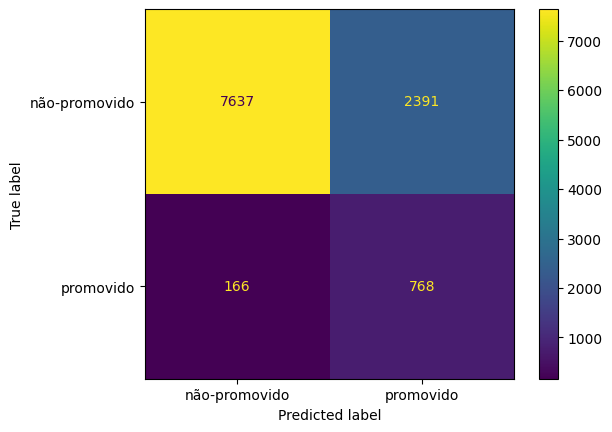

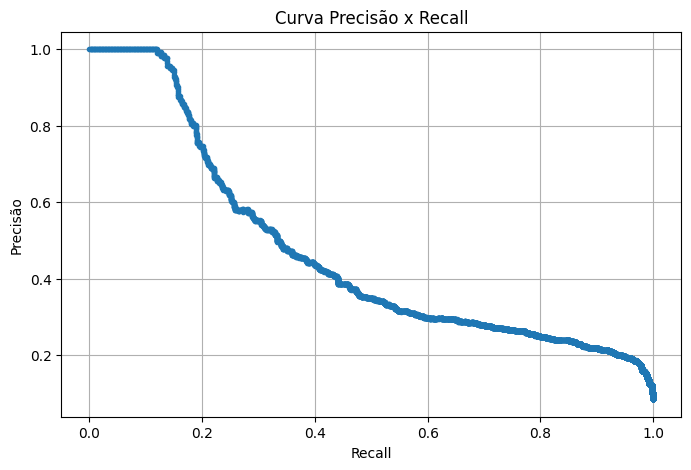

In [21]:
# ============================================================
# 13. Treino, validação e avaliação do melhor modelo da CV
# ============================================================

melhor_modelo = modelos["Regressao_Logistica"]
pipeline = Pipeline(steps=[
    ("transforma_tipos", transforma_tipos),
    ("transforma_variaveis", transforma_variaveis),
    ("preprocessador", preprocessador),
    ("modelo", melhor_modelo)
])

pipeline.fit(X_treino, y_treino)
predicoes = pipeline.predict(X_val)
probabilidades = pipeline.predict_proba(X_val)[:, 1]

print(f"\n=== Avaliação do modelo: Regresso Logistica ===")
exibir_metricas(y_val, predicoes, probabilidades)

precisoes, recalls, limiares = precision_recall_curve(y_val, probabilidades)

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisoes, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precisão x Recall")
plt.grid(True)
plt.show()

Melhor threshold pelo F1: 0.81 | F1: 0.4222
Recall: 0.4390
AUCPR: 0.4705
F2 Score: 0.4321

Relatório completo:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94     10028
           1       0.41      0.44      0.42       934

    accuracy                           0.90     10962
   macro avg       0.68      0.69      0.68     10962
weighted avg       0.90      0.90      0.90     10962



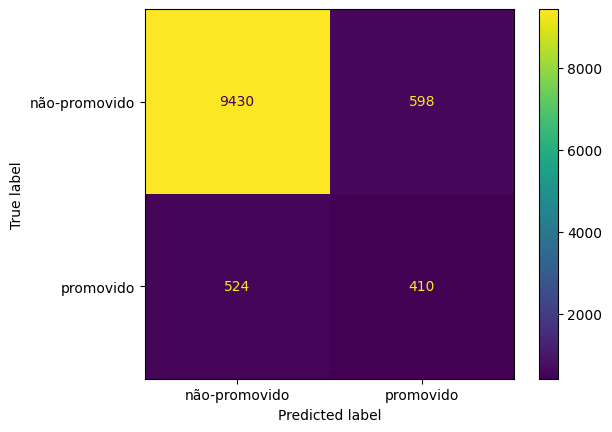

In [22]:
# ============================================================
# 14. Ajusto o threshold para melhorar a detecção dos promovidos
# ============================================================

melhor_f1 = 0
melhor_threshold = 0.5

for t in limiares:
    preds_limite = (probabilidades >= t).astype(int)
    f1 = f1_score(y_val, preds_limite)
    if f1 > melhor_f1:
        melhor_f1 = f1
        melhor_threshold = t

print(f"Melhor threshold pelo F1: {melhor_threshold:.2f} | F1: {melhor_f1:.4f}")

preds_ajustadas = (probabilidades >= melhor_threshold).astype(int)
exibir_metricas(y_val, preds_ajustadas, probabilidades)

In [23]:
# ============================================================
# 15. Aplico o modelo final no dataset de teste
# ============================================================

pipeline_final = Pipeline(steps=[
    ("transforma_tipos", transforma_tipos),
    ("transforma_variaveis", transforma_variaveis),
    ("preprocessador", preprocessador),
    ("modelo", melhor_modelo)
])

pipeline_final.fit(X, y)

probs_teste = pipeline_final.predict_proba(df_teste)[:, 1]
preds_teste_ajustadas = (probs_teste >= melhor_threshold).astype(int)

In [24]:
# ============================================================
# 16. Salvo o modelo e as previsões finais
# ============================================================

resultado_final = pd.DataFrame({
    "matricula": df_teste["matricula"],
    "promovido": preds_teste_ajustadas
})
resultado_final.to_csv("predicoes_v1_0_threshold.csv", index=False)

# Salvo o pipeline final treinado
joblib.dump(pipeline_final, "modelo_final_v1.pkl")

['modelo_final_v1.pkl']

## Tunning do Modelo

In [25]:
# ============================================================
# 17. Fine tuning com Optuna para otimizar hiperparâmetros
# ============================================================

def objetivo(trial):
    # Escolha do modelo
    nome_modelo = trial.suggest_categorical("modelo", ["DecisionTree", "RandomForest", "LogisticRegression"])

    passo_preprocessamento = ("preprocessador", preprocessador)

    # Undersampling para balancear
    undersampler = ("undersampler", RandomUnderSampler(random_state=42))

    # Defino hiperparâmetros conforme modelo
    if nome_modelo == "DecisionTree":
        criterio = trial.suggest_categorical("criterio", ["gini", "entropy"])
        profundidade_max = trial.suggest_int("max_depth", 2, 50)
        min_amostra_split = trial.suggest_int("min_samples_split", 2, 10)
        modelo = DecisionTreeClassifier(
            criterion=criterio,
            max_depth=profundidade_max,
            min_samples_split=min_amostra_split,
            class_weight="balanced",
            random_state=42
        )

    elif nome_modelo == "RandomForest":
        n_estimadores = trial.suggest_int("n_estimators", 50, 300, step=50)
        profundidade_max = trial.suggest_int("max_depth", 2, 50)
        min_amostra_split = trial.suggest_int("min_samples_split", 2, 10)
        modelo = RandomForestClassifier(
            n_estimators=n_estimadores,
            max_depth=profundidade_max,
            min_samples_split=min_amostra_split,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )

    else:  # Regressão Logística
        C = trial.suggest_float("C", 1e-4, 10, log=True)
        penalidade = trial.suggest_categorical("penalty", ["l2"])
        solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear"])
        modelo = LogisticRegression(
            C=C,
            penalty=penalidade,
            solver=solver,
            class_weight="balanced",
            max_iter=1000,
            random_state=42
        )

    # Pipeline com preprocessamento, undersampling e modelo
    pipeline_otim = ImbPipeline(steps=[
        passo_preprocessamento,
        undersampler,
        ("modelo", modelo)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    resultados = cross_val_score(
        pipeline_otim,
        X,
        y,
        cv=cv,
        scoring="recall"  # foco em recall
    )

    return resultados.mean()

# Executo o estudo Optuna
estudo = optuna.create_study(direction="maximize")
estudo.optimize(objetivo, n_trials=50, n_jobs=-1)  # ajuste n_trials conforme necessário

print("Número de trials finalizados:", len(estudo.trials))
print("Melhor recall médio:", estudo.best_value)
print("Melhores parâmetros:", estudo.best_params)

[I 2025-08-30 19:20:14,585] A new study created in memory with name: no-name-1d97e70f-85d4-4789-858a-aff5c517225d
[I 2025-08-30 19:20:42,169] Trial 1 finished with value: 0.7756994888813915 and parameters: {'modelo': 'DecisionTree', 'criterio': 'entropy', 'max_depth': 3, 'min_samples_split': 3}. Best is trial 1 with value: 0.7756994888813915.
[I 2025-08-30 19:20:42,763] Trial 4 finished with value: 0.9183844337186805 and parameters: {'modelo': 'DecisionTree', 'criterio': 'entropy', 'max_depth': 8, 'min_samples_split': 9}. Best is trial 4 with value: 0.9183844337186805.
[I 2025-08-30 19:20:43,452] Trial 2 finished with value: 0.8322594563827858 and parameters: {'modelo': 'DecisionTree', 'criterio': 'entropy', 'max_depth': 20, 'min_samples_split': 5}. Best is trial 4 with value: 0.9183844337186805.
[I 2025-08-30 19:20:44,601] Trial 8 finished with value: 0.8121314357452531 and parameters: {'modelo': 'LogisticRegression', 'C': 0.07381400781078551, 'penalty': 'l2', 'solver': 'liblinear'}. 

Número de trials finalizados: 50
Melhor recall médio: 0.9183844337186805
Melhores parâmetros: {'modelo': 'DecisionTree', 'criterio': 'entropy', 'max_depth': 8, 'min_samples_split': 9}


Melhor modelo encontrado: {'modelo': 'DecisionTree', 'criterio': 'entropy', 'max_depth': 8, 'min_samples_split': 9}
Recall médio (validação cruzada): 0.9184 ± 0.0108
Recall: 0.9368
AUCPR: 0.5271
F2 Score: 0.5534

Relatório completo:
               precision    recall  f1-score   support

           0       0.99      0.67      0.80     50140
           1       0.21      0.94      0.34      4668

    accuracy                           0.69     54808
   macro avg       0.60      0.80      0.57     54808
weighted avg       0.92      0.69      0.76     54808



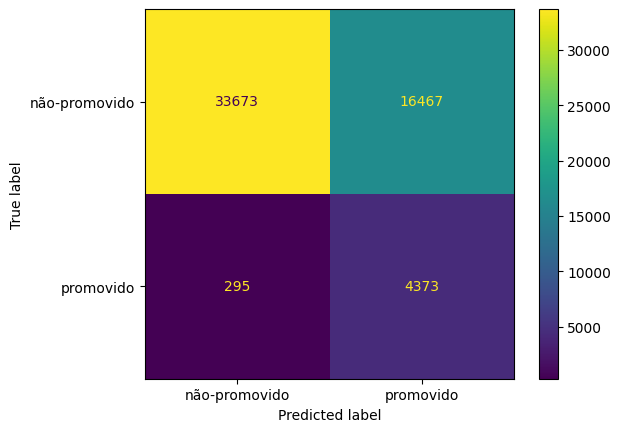

In [26]:
# ============================================================
# 18. Construção do modelo com melhor configuração do Optuna (v1)
# ============================================================

# Recupero os melhores parâmetros do estudo
melhores_parametros = estudo.best_params
print("Melhor modelo encontrado:", melhores_parametros)

# Recrio o modelo com os melhores hiperparâmetros
if melhores_parametros["modelo"] == "DecisionTree":
    melhor_modelo = DecisionTreeClassifier(
        criterion=melhores_parametros["criterio"],
        max_depth=melhores_parametros["max_depth"],
        min_samples_split=melhores_parametros["min_samples_split"],
        class_weight="balanced",
        random_state=42
    )

elif melhores_parametros["modelo"] == "RandomForest":
    melhor_modelo = RandomForestClassifier(
        n_estimators=melhores_parametros["n_estimators"],
        max_depth=melhores_parametros["max_depth"],
        min_samples_split=melhores_parametros["min_samples_split"],
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

else:  # Regressão Logística
    melhor_modelo = LogisticRegression(
        C=melhores_parametros["C"],
        penalty=melhores_parametros["penalty"],
        solver=melhores_parametros["solver"],
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    )

# Pipeline final com preprocessamento, undersampling e modelo
pipeline_final_optuna = ImbPipeline(steps=[
    ("preprocessador", preprocessador),
    ("undersampler", RandomUnderSampler(random_state=42)),
    ("modelo", melhor_modelo)
])

# Treino com todo o dataset
pipeline_final_optuna.fit(X, y)

# Validação cruzada para recall médio
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_final_optuna, X, y, cv=cv, scoring="recall")

print(f"Recall médio (validação cruzada): {scores.mean():.4f} ± {scores.std():.4f}")

# Previsões para avaliação detalhada no treino
y_pred_treino = pipeline_final_optuna.predict(X)
y_proba_treino = pipeline_final_optuna.predict_proba(X)[:, 1]

exibir_metricas(y, y_pred_treino, y_proba_treino)

In [27]:
# ============================================================
# 19. Validação do melhor threshold com recall alvo >= 60%
# ============================================================

def escolher_threshold_alvo_recall(y_verdadeiro, y_proba, recall_alvo=0.60):
    """Seleciona threshold com recall >= recall_alvo e maior F2."""
    precisao, recall, thresholds = precision_recall_curve(y_verdadeiro, y_proba)
    thresholds = np.append(thresholds, 1.0)  # para alinhar arrays
    
    candidatos = []
    for p, r, t in zip(precisao, recall, thresholds):
        if r >= recall_alvo:
            f2 = (5 * p * r) / (4 * p + r) if (4 * p + r) > 0 else 0
            candidatos.append((f2, t))
    
    if candidatos:
        candidatos.sort(reverse=True)  # ordena por F2 decrescente
        return float(candidatos[0][1])
    else:
        return 0.5  # fallback

def avaliar_fold(y_verdadeiro, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    precisao = precision_score(y_verdadeiro, y_pred, zero_division=0)
    recall = recall_score(y_verdadeiro, y_pred)
    f2 = fbeta_score(y_verdadeiro, y_pred, beta=2)
    pr_prec, pr_rec, _ = precision_recall_curve(y_verdadeiro, y_proba)
    aucpr = auc(pr_rec, pr_prec)
    return {"precision": precisao, "recall": recall, "F2": f2, "AUCPR": aucpr, "threshold": threshold}

def relatorio_cv_com_recall_alvo(pipeline, X, y, recall_alvo=0.60, n_splits=5, random_state=42):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    resultados = []
    for idx_treino, idx_val in cv.split(X, y):
        X_tr, X_va = X.iloc[idx_treino], X.iloc[idx_val]
        y_tr, y_va = y.iloc[idx_treino], y.iloc[idx_val]
        pipeline.fit(X_tr, y_tr)
        y_proba = pipeline.predict_proba(X_va)[:, 1]
        thresh = escolher_threshold_alvo_recall(y_va, y_proba, recall_alvo)
        resultados.append(avaliar_fold(y_va, y_proba, thresh))
    df_resultados = pd.DataFrame(resultados)
    resumo = df_resultados.mean().to_dict()
    return df_resultados, resumo

resultados_modelos = []
for nome, modelo in modelos.items():
    pipeline_cv = ImbPipeline(steps=[
        ("preprocessor", preprocessador),
        ("undersampler", RandomUnderSampler(random_state=42)),
        ("model", modelo)
    ])
    df_cv, resumo_cv = relatorio_cv_com_recall_alvo(pipeline_cv, X, y, recall_alvo=0.60, n_splits=5)
    resumo_cv["modelo"] = nome
    resultados_modelos.append(resumo_cv)

tabela_resultados = pd.DataFrame(resultados_modelos).set_index("modelo").sort_values(["recall","AUCPR"], ascending=False)
print(tabela_resultados[["recall","precision","F2","AUCPR","threshold"]])

                     recall  precision   F2  AUCPR  threshold
modelo                                                       
Random_Forest          0.88       0.24 0.57   0.43       0.51
Regressao_Logistica    0.88       0.23 0.56   0.46       0.43
Arvore_Decisao         0.76       0.23 0.52   0.51       0.90


[I 2025-08-30 19:29:57,875] A new study created in memory with name: no-name-230c50c3-6544-4e46-9947-e158d41e541d
[I 2025-08-30 19:30:31,241] Trial 6 finished with value: 0.7600684857623516 and parameters: {'modelo': 'DecisionTree', 'criterio': 'entropy', 'max_depth': 39, 'min_samples_split': 5}. Best is trial 6 with value: 0.7600684857623516.
[I 2025-08-30 19:30:33,990] Trial 8 finished with value: 0.7609296070101512 and parameters: {'modelo': 'DecisionTree', 'criterio': 'gini', 'max_depth': 27, 'min_samples_split': 3}. Best is trial 8 with value: 0.7609296070101512.
[I 2025-08-30 19:30:34,631] Trial 10 finished with value: 0.7562122599613047 and parameters: {'modelo': 'DecisionTree', 'criterio': 'entropy', 'max_depth': 47, 'min_samples_split': 9}. Best is trial 8 with value: 0.7609296070101512.
[I 2025-08-30 19:30:34,990] Trial 7 finished with value: 0.7485007263989204 and parameters: {'modelo': 'DecisionTree', 'criterio': 'gini', 'max_depth': 31, 'min_samples_split': 3}. Best is tri

Terminei 50 trials no total
Melhor recall médio que encontrei: 0.9182
Melhores parâmetros pelo Optuna: {'modelo': 'RandomForest', 'n_estimators': 250, 'max_depth': 19, 'min_samples_split': 4}
Depois do filtro de recall >= 0.60, escolhi esses parâmetros: {'modelo': 'RandomForest', 'n_estimators': 250, 'max_depth': 19, 'min_samples_split': 4}
Recall: 0.9690
AUCPR: 0.6125
F2 Score: 0.5848

Relatório completo:
               precision    recall  f1-score   support

           0       1.00      0.69      0.82     10028
           1       0.23      0.97      0.37       934

    accuracy                           0.71     10962
   macro avg       0.61      0.83      0.59     10962
weighted avg       0.93      0.71      0.78     10962



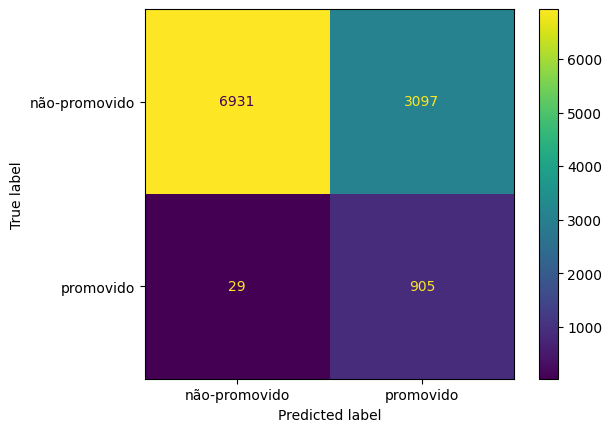

In [28]:
# ============================================================
# 20. Continuo o estudo com Optuna: escolho e avalio os top-5 modelos com recall mínimo de 60%
# ============================================================

def construir_modelo_a_partir_dos_params(params):
    """Aqui eu reconstruo o pipeline completo usando os parâmetros que o Optuna me deu."""
    nome_modelo = params["modelo"]

    preprocessor_step = ("preprocessor", preprocessador)
    undersampler = ("undersampler", RandomUnderSampler(random_state=42))

    if nome_modelo == "DecisionTree":
        modelo = DecisionTreeClassifier(
            criterion=params.get("criterion", "gini"),
            max_depth=params.get("max_depth", None),
            min_samples_split=params.get("min_samples_split", 2),
            class_weight="balanced",
            random_state=42
        )

    elif nome_modelo == "RandomForest":
        modelo = RandomForestClassifier(
            n_estimators=params.get("n_estimators", 100),
            max_depth=params.get("max_depth", None),
            min_samples_split=params.get("min_samples_split", 2),
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )

    elif nome_modelo == "LogisticRegression":
        modelo = LogisticRegression(
            C=params.get("C", 1.0),
            penalty=params.get("penalty", "l2"),
            solver=params.get("solver", "lbfgs"),
            class_weight="balanced",
            max_iter=1000,
            random_state=42
        )

    else:
        raise ValueError(f"Modelo não suportado: {nome_modelo}")

    pipeline = ImbPipeline(steps=[
        preprocessor_step,
        undersampler,
        ("model", modelo)
    ])

    return pipeline

# Agora eu executo o Optuna para encontrar os melhores hiperparâmetros
study = optuna.create_study(direction="maximize")
study.optimize(objetivo, n_trials=50, n_jobs=-1)

# Depois, pego os 5 melhores trials ordenados pelo recall médio (do maior para o menor)
top_5_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:5]

ranking = []
for trial in top_5_trials:
    modelo_pipeline = construir_modelo_a_partir_dos_params(trial.params)
    _, resumo_metricas = relatorio_cv_com_recall_alvo(modelo_pipeline, X, y, recall_alvo=0.60, n_splits=5)
    ranking.append((trial.params, resumo_metricas["recall"], resumo_metricas["AUCPR"], resumo_metricas["F2"]))

# Filtrar para ficar só com modelos que têm recall >= 0.60 e ordenar pelos melhores AUCPR e F2
ranking_filtrado = sorted(
    [item for item in ranking if item[1] >= 0.60],
    key=lambda x: (x[2], x[3]),
    reverse=True
)

# Escolho os parâmetros que têm o maior AUCPR entre os que passam o recall mínimo
params_escolhidos = ranking_filtrado[0][0]

print(f"Terminei {len(study.trials)} trials no total")
print(f"Melhor recall médio que encontrei: {study.best_value:.4f}")
print(f"Melhores parâmetros pelo Optuna: {study.best_params}")
print(f"Depois do filtro de recall >= 0.60, escolhi esses parâmetros: {params_escolhidos}")

# Por fim, treino o modelo com os parâmetros escolhidos usando todo o conjunto de treino
melhor_modelo = construir_modelo_a_partir_dos_params(params_escolhidos)
melhor_modelo.fit(X, y)

# Avalio o desempenho no conjunto de validação
y_pred_val = melhor_modelo.predict(X_val)
y_proba_val = melhor_modelo.predict_proba(X_val)[:, 1]
exibir_metricas(y_val, y_pred_val, y_proba_val)

In [29]:
# ============================================================
# 21. Analisando o ranking 
# ============================================================
# Cria DataFrame para visualização, definindo nomes das colunas
df_ranking = pd.DataFrame(ranking, columns=["params", "recall", "AUCPR", "F2"])

# Filtra por recall >= 0.60 e ordena por AUCPR e depois F2
df_ranking = df_ranking[df_ranking["recall"] >= 0.60].sort_values(
    by=["AUCPR", "F2"], ascending=False
).reset_index(drop=True)

# Mostra ranking tabulado
pd.set_option('display.float_format', '{:.6f}'.format)
print("\nRanking dos modelos (recall >= 0.60):")
display(df_ranking)


Ranking dos modelos (recall >= 0.60):


,params,recall,AUCPR,F2
0,"{'modelo': 'RandomForest', 'n_estimators': 250, 'max_depth': 19, 'min_samples_split': 4}",0.902952,0.459280,0.563769
1,"{'modelo': 'RandomForest', 'n_estimators': 250, 'max_depth': 19, 'min_samples_split': 4}",0.902952,0.459280,0.563769
2,"{'modelo': 'RandomForest', 'n_estimators': 300, 'max_depth': 19, 'min_samples_split': 4}",0.925649,0.459012,0.564583
3,"{'modelo': 'RandomForest', 'n_estimators': 300, 'max_depth': 19, 'min_samples_split': 4}",0.925649,0.459012,0.564583
4,"{'modelo': 'RandomForest', 'n_estimators': 300, 'max_depth': 19, 'min_samples_split': 4}",0.925649,0.459012,0.564583


Threshold escolhido para garantir recall >= 0.60: 0.66
Avaliação do Modelo
Recall:     0.8394
F2 Score:   0.6506
AUC-PR:     0.6125
AUC-ROC:    0.9308

Relatório completo:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91     10028
           1       0.34      0.84      0.49       934

    accuracy                           0.85     10962
   macro avg       0.66      0.84      0.70     10962
weighted avg       0.93      0.85      0.88     10962



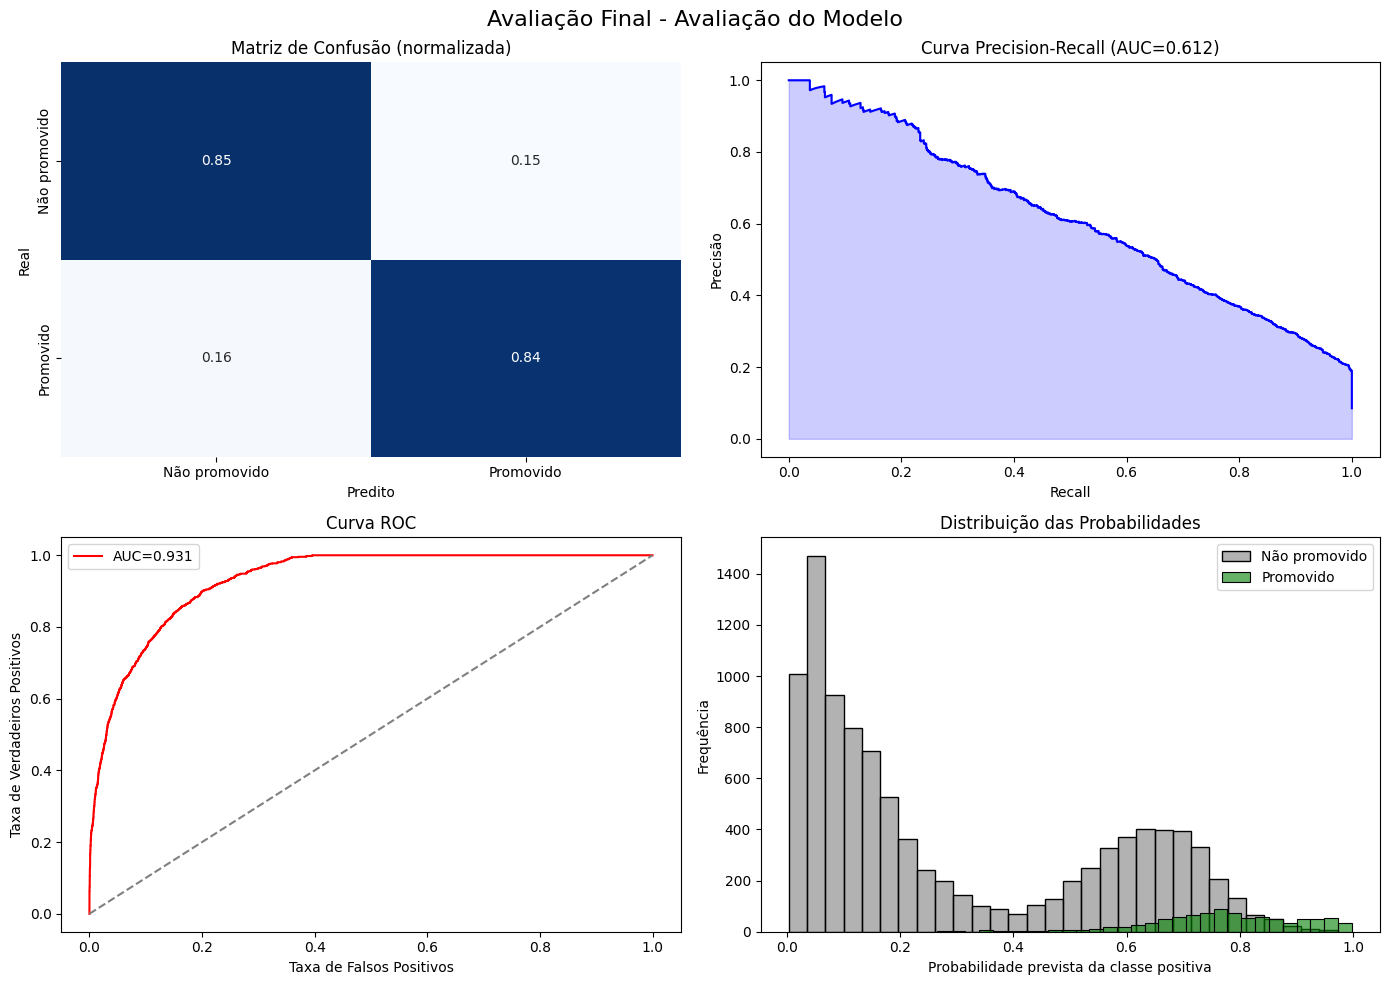

In [30]:
# ============================================================
# 22. Escolha e avaliação do modelo final com threshold ajustado
# ============================================================

# Construo o modelo final a partir dos melhores parâmetros encontrados
best_model = construir_modelo_a_partir_dos_params(params_escolhidos)

# Treino o modelo no conjunto de treino completo
best_model.fit(X, y)

# Gero as probabilidades de previsão no conjunto de validação
y_proba = best_model.predict_proba(X_val)[:, 1]

# Encontro o threshold que garante recall >= 0.60 com o melhor F2 possível
threshold_final = escolher_threshold_alvo_recall(y_val, y_proba, recall_alvo=0.60)
print(f"Threshold escolhido para garantir recall >= 0.60: {threshold_final:.2f}")

# Aplico esse threshold customizado para gerar as previsões binárias finais
y_pred_custom = (y_proba >= threshold_final).astype(int)

# Avalio os resultados finais usando o threshold ajustado (aqui a métrica mais completa, para a versão final)
avaliacao_completa(y_val, y_pred_custom, y_proba)

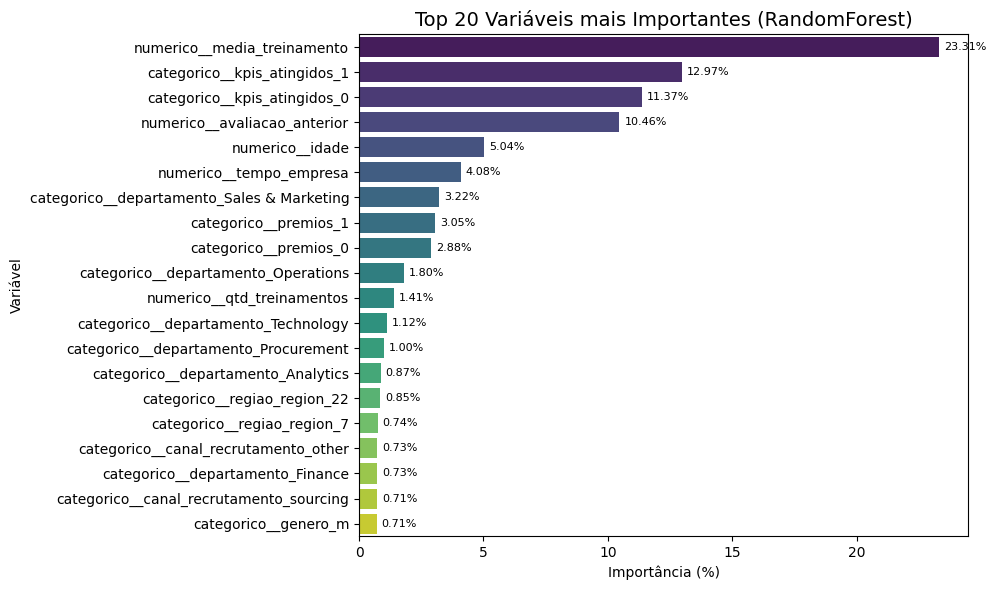

                                       feature  importancia_pct  \
0                  numerico__media_treinamento        23.308627   
1                 categorico__kpis_atingidos_1        12.969467   
2                 categorico__kpis_atingidos_0        11.373820   
3                 numerico__avaliacao_anterior        10.463573   
4                              numerico__idade         5.036546   
5                      numerico__tempo_empresa         4.077745   
6   categorico__departamento_Sales & Marketing         3.224609   
7                        categorico__premios_1         3.051150   
8                        categorico__premios_0         2.883235   
9          categorico__departamento_Operations         1.795265   
10                  numerico__qtd_treinamentos         1.405336   
11         categorico__departamento_Technology         1.116456   
12        categorico__departamento_Procurement         1.004882   
13          categorico__departamento_Analytics         0.87176

In [31]:
# ============================================================
# 23. Importância das variáveis (com visualização)
# ============================================================
'''
Para essa análise, rodamos novamente o modelo, por conta das transformações, uma vez que alguns dos dados precisam ser 
os dados de entrada (originais)
'''

# Reamostragem com RUS
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X, y)

# Pipeline para importância
pipeline_fi = Pipeline([
    ("preprocessador", best_model.named_steps["preprocessor"]),
    ("modelo", RandomForestClassifier(
        class_weight="balanced",
        max_depth=22,
        min_samples_split=9,
        n_estimators=250,
        n_jobs=-1,
        random_state=42
    ))
])

# Treino
pipeline_fi.fit(X_train_res, y_train_res)

# Importâncias
importancias = pipeline_fi.named_steps["modelo"].feature_importances_
nomes_features = pipeline_fi.named_steps["preprocessador"].get_feature_names_out()

df_importancia = pd.DataFrame({
    "feature": nomes_features,
    "importancia": importancias
}).sort_values(by="importancia", ascending=False).reset_index(drop=True)

# Normaliza em percentual
df_importancia["importancia_pct"] = 100 * df_importancia["importancia"] / df_importancia["importancia"].sum()
df_importancia["importancia_acumulada"] = df_importancia["importancia_pct"].cumsum()

# Seleciona top 20
top_n = 20
df_top = df_importancia.head(top_n)

# --- Gráfico ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_top,
    x="importancia_pct",
    y="feature",
    hue="feature",
    palette="viridis",
    dodge=False,             # evita barras duplicadas ao usar `hue`
    legend=False
)

# Adiciona os valores no gráfico
for i, v in enumerate(df_top["importancia_pct"]):
    plt.text(v + 0.2, i, f"{v:.2f}%", va="center", fontsize=8)

plt.title(f"Top {top_n} Variáveis mais Importantes (RandomForest)", fontsize=14)
plt.xlabel("Importância (%)")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

# Mostra tabela resumida
print(df_top[["feature", "importancia_pct", "importancia_acumulada"]])

O que os dados mostram?

num__media_treinamento (0.2335)
Essa é a variável com maior importância, contribuindo com cerca de 23,35% da decisão do modelo. Ou seja, a média de treinamentos que o funcionário fez tem o maior impacto na previsão.

cat__kpis_atingidos_0 (0.1185) e cat__kpis_atingidos_1 (0.1176)
Essas duas variáveis categóricas representam os dois níveis (0 e 1) da variável kpis_atingidos (indicador binário). Juntas, somam quase 24% da importância, mostrando que esse KPI atingido é muito relevante para a classificação.

num__avaliacao_anterior (0.0961)
Avaliação anterior do funcionário é a terceira mais importante variável numérica, com cerca de 9,6% de impacto.

num__idade (0.0524)
Idade do funcionário, com influência menor, mas ainda significativa.

num__tempo_empresa (0.0438)
Tempo na empresa também é um fator que o modelo considera relevante.

As variáveis categóricas de departamento, premios, etc, aparecem com importâncias menores, espalhadas em várias categorias (ex: diferentes departamentos têm importâncias específicas).

É interessante notar que algumas categorias como cat__departamento_Sales & Marketing e cat__departamento_Operations aparecem, indicando que essas categorias têm influência diferente na predição.

Conclusão geral

O modelo está priorizando mais variáveis numéricas relacionadas ao desempenho e experiência do funcionário (media_treinamento, avaliacao_anterior, idade, tempo_empresa).

Variáveis categóricas importantes são principalmente kpis_atingidos e alguns departamentos específicos.

Algumas variáveis categóricas aparecem duplicadas porque são representações one-hot de categorias diferentes dentro da mesma variável.

In [32]:
print(best_model)
print(params_escolhidos)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerico',
                                                  Pipeline(steps=[('imputacao',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('padronizacao',
                                                                   StandardScaler())]),
                                                  ['qtd_treinamentos', 'idade',
                                                   'avaliacao_anterior',
                                                   'tempo_empresa',
                                                   'media_treinamento']),
                                                 ('categorico',
                                                  Pipeline(steps=[('imputacao',
                                                                   SimpleImputer(strategy='most_frequent')),
    

### 📊 Análise Final do Modelo de Classificação Vencedor: Random Forest

**Threshold --> 0.66**: o intuito escolhido foi garantir um **recall maior ou igual a 0.60**, pensando em um cenário que pudéssemos obter maior percentual de acerto/identificação em talentos (promoção efetiva), uma vez que ao errar um caso de promoção (falso negativo), isso seria impactado pela perda de um talento importante.

---

#### 🔍 Avaliação Geral do Modelo

| Métrica        | Valor        | Interpretação                                                                 |
|----------------|--------------|------------------------------------------------------------------------------|
| **Recall (classe 1)** | 0.8394       | O modelo consegue identificar a maioria dos promovidos reais. Isso era meu principal objetivo. |
| **F2 Score**    | 0.6506       | A métrica F2 prioriza o recall e reforça a capacidade do modelo em identificar talentos. |
| **AUC-PR**      | 0.6125       | A precisão a classe 1 está baixa, no entanto, para a classe 0 ficou excelente. O intuito de se ter um modelo com recall priorizado a classe 1 para 60% já previa que isso possivelmente aconteceria. |
| **AUC-ROC**     | 0.9308       | Excelente separação entre classes, indicando que o modelo tem boa capacidade discriminativa. |

---

#### 📌 Interpretação da Matriz de Confusão

|                | Predito: Não promovido | Predito: Promovido |
|----------------|------------------------|---------------------|
| **Real: Não promovido** | 0.85 (TN)              | 0.15 (FP)          |
| **Real: Promovido**     | 0.16 (FN)              | 0.84 (TP)          |

- O modelo identificou **84% dos promovidos reais**, o que confirma o alto recall.
- No entanto, **15% dos não promovidos foram classificados como promovidos**, o que pode gerar ruídos ou expectativas indevidas.

---

#### 📈 Curva Precision-Recall (AUC = 0.6125)

- Esta curva mostra o equilíbrio entre **precisão** e **recall**.
- A área abaixo da curva (**AUC-PR**) demonstra um equilíbrio que podemos considerar como aceitável, uma vez que indica que o modelo **acerta muitos promovidos**, mas **erra também, mesmo que com menor frequência**.
- Aqui percebo que o modelo **traz alguns falsos positivos**, comprometendo (principalmente para a classe 1) a **precisão**, mesmo que em contrapartida tenha um ótimo **recall** para esta mesma classe.

---

#### 📈 Curva ROC (AUC = 0.9308)

- A curva ROC mostra a relação entre **taxa de verdadeiros positivos (recall)** e **falsos positivos**.
- O modelo apresenta uma excelente **AUC-ROC de 0.9308**, indicando que consegue **diferenciar bem as duas classes**.
- No entanto, é preciso considerar que essa métrica da **ROC é menos sensível ao desbalanceamento**, até por isso, neste caso se torna mais prudente considerar com maior importância a métrica analisada via **precision-recall**.

---

#### 📊 Distribuição das Probabilidades

- Há uma boa separação entre as classes, em que a maioria dos não promovidos recebeu probabilidades muito baixas próximas de 0), enquanto os promovidos aparecem mais concentrados acima de 0.6, indicando que o modelo diferencia bem os casos mais claros
- O threshold de 0.66 se mostra coerente, já que a maior parte dos promovidos está acima desse valor
- Ainda assim houve alguma sobreposição entre as classes numa faixa mais intermediária, mostrando que o modelo tem mais dificuldade de classificar corretamente os casos menos evidentes
- Houve falsos negativos abaixo do threshold, isso pode ser visto pelos pontos verdes (promovidos) com probabilidade abaixo de 0.64, sendo os casos que o modelo não conseguiu identificar como positivos, mesmo sendo
- Por outro lado, há poucos falsos positivos acima do threshold, demonstrando que o modelo parece ser conservador, mesmo que a intenção seja não ter perda de talentos na identificação/previsão de uma promoção.

---

#### 📄 Relatório de Classificação

|Target| Precision | Recall | f1-score | support |
|---|---|---|---|---|
|Classe 0 | 0.98 | 0.85 | 0.91 | 10028 |
|Classe 1 | 0.34 | 0.84 | 0.49 | 934 |

- Quando o funcionário realmente **não foi promovido**, o modelo acerta **85%** das vezes.
- Quando o funcionário realmente **foi promovido**, o modelo acerta **84%** das vezes. No entanto, quando ele prediz 'promovido', acerta apenas 35% das vezes
- Isso reforça que estou **otimizando o recall**, aceitando uma perda considerável na **precisão da classe promovido**.

---

#### ✅ Conclusões e Próximos Passos

- O modelo está **adequado para uma estratégia que visa o contexto/objetivo em que, perder um promovido é mais custoso do que promover alguém indevidamente**. Desta forma, este modelo prevê sua utilização como uma **ferramenta de apoio à decisão**, e não como critério absoluto de promoção. Portanto, o mais correto e coerente é **validar o impacto com o RH ou líderes**, para verificar a aplicabilidade do modelo proposto ao ambiente corporativo, validando assim se o recall alto realmente ajuda a **não perder talentos valiosos**. Desta forma, poderíamos resumir que este poderia ser um uso aplicado como parte de um **sistema de recomendação de candidatos internos**, sempre associado à avaliação humana.

# Predição Final e Comparação dos Resultados: Predição Final vs. Dados de Treino

In [33]:
# ============================================================
# 24. Predição Final 
# ============================================================
print(f"Threshold Final - Predição:{threshold_final:.5f}")
y_proba_novos = best_model.predict_proba(df_teste)[:, 1]

# Aplica o threshold final escolhido
y_pred_novos = (y_proba_novos >= threshold_final).astype(int)

df_resultado = df_teste.copy()
df_resultado["prob_promocao"] = y_proba_novos
df_resultado["promovido"] = y_pred_novos
df_resultado.head()

Threshold Final - Predição:0.65788


,matricula,departamento,regiao,escolaridade,genero,canal_recrutamento,qtd_treinamentos,idade,avaliacao_anterior,tempo_empresa,kpis_atingidos,premios,media_treinamento,prob_promocao,promovido
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77,0.666473,1
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.000000,5,0,0,51,0.157967,0
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.000000,4,0,0,47,0.038776,0
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.000000,9,0,0,65,0.121869,0
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.000000,7,0,0,61,0.080318,0


In [34]:
# ===============================
# 25. Salvando modelo e resultados
# ===============================

df_resultado.to_csv("predicoes_v2_0_threshold.csv", index=False)

# Salvar modelo treinado
joblib.dump(best_model, "modelo_final_v2.pkl")

['modelo_final_v2.pkl']

## Analisando proporção dos Promovidos

In [35]:
# ===============================
# 26. Proporção dos Promovidos
# ===============================

pd.set_option('display.float_format', '{:.4f}'.format)
print(f"\n=== (DF Resultado - Predição Final) ===")
print(df_resultado['promovido'].value_counts(normalize=True))
print(f"\n=== (DF Treino - Dados Originais) ===")
df_treino['promovido'].value_counts(normalize=True)


=== (DF Resultado - Predição Final) ===
promovido
0   0.8411
1   0.1589
Name: proportion, dtype: float64

=== (DF Treino - Dados Originais) ===


promovido
0   0.9148
1   0.0852
Name: proportion, dtype: float64

In [36]:
# ===============================
# 27. Função para comparar distribuições de promovidos e teste estatísticos qui-quadrado com principais indicadores
# ===============================

def analisar_indicador_completo(df_treino, df_resultado, indicador):    

    def adicionar_labels_percentual(eixo):
        for contorno in eixo.containers:
            for barra in contorno:
                altura = barra.get_height()
                if altura > 0:
                    eixo.annotate(f'{altura:.0%}',
                                  xy=(barra.get_x() + barra.get_width() / 2, barra.get_y() + altura / 2),
                                  ha='center', va='center', fontsize=9, color='white', weight='bold')

    figura, eixos = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    plt.suptitle(f'Indicador: {indicador}', fontsize=16, weight='bold')

    resultados = {}

    for i, (df, nome_df, eixo) in enumerate(zip([df_treino, df_resultado], ['Treino', 'Resultado'], eixos)):
        print(f"\n--- Análise: {indicador} ({nome_df}) ---")

        # Tabela cruzada
        tabela_frequencia = pd.crosstab(df[indicador], df['promovido'])
        print("Crosstab (Frequência Absoluta):")
        print(tabela_frequencia)

        # Proporção por categoria
        tabela_proporcao = pd.crosstab(df[indicador], df['promovido'], normalize='index')
        print("\nProporção por categoria:")
        print(tabela_proporcao)

        # Teste Qui-quadrado
        qui2, p_valor, graus_liberdade, esperada = chi2_contingency(tabela_frequencia)
        print(f"\n📊 Teste Qui-Quadrado:")
        print(f"Chi2 = {qui2:.4f}, p-value = {p_valor:.4f}, DOF = {graus_liberdade}")
        if p_valor < 0.05:
            print("🚨 Diferença significativa detectada nas distribuições!")
        else:
            print("✅ Sem diferença estatisticamente significativa.")

        # Preparar dados para o gráfico
        dados_grafico = tabela_proporcao.reset_index().melt(
            id_vars=indicador, var_name='Promovido', value_name='Proporcao'
        )

        # Gráfico de barras empilhadas
        sns.barplot(data=dados_grafico, x=indicador, y='Proporcao', hue='Promovido', ax=eixo)
        eixo.set_title(f'{nome_df} (p = {p_valor:.4f})')
        eixo.set_ylabel('Proporção')
        eixo.set_xlabel(indicador)

        # Ajuste da rotação dos rótulos
        for rotulo in eixo.get_xticklabels():
            rotulo.set_rotation(30)
            rotulo.set_ha('right')

        eixo.legend(title='Promovido')
        adicionar_labels_percentual(eixo)

        # Armazenar os resultados
        resultados[nome_df] = {
            'chi2': qui2,
            'p_value': p_valor,
            'graus_liberdade': graus_liberdade,
            'esperado': esperada,
            'tabela': tabela_frequencia,
            'proporcao': tabela_proporcao
        }

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return resultados


===== Analisando: ESCOLARIDADE =====

--- Análise: escolaridade (Treino) ---
Crosstab (Frequência Absoluta):
promovido             0     1
escolaridade                 
Bachelor's        33661  3008
Below Secondary     738    67
Master's & above  13454  1471

Proporção por categoria:
promovido             0      1
escolaridade                  
Bachelor's       0.9180 0.0820
Below Secondary  0.9168 0.0832
Master's & above 0.9014 0.0986

📊 Teste Qui-Quadrado:
Chi2 = 36.7030, p-value = 0.0000, DOF = 2
🚨 Diferença significativa detectada nas distribuições!

--- Análise: escolaridade (Resultado) ---
Crosstab (Frequência Absoluta):
promovido             0     1
escolaridade                 
Bachelor's        13465  2113
Below Secondary     316    58
Master's & above   5094  1410

Proporção por categoria:
promovido             0      1
escolaridade                  
Bachelor's       0.8644 0.1356
Below Secondary  0.8449 0.1551
Master's & above 0.7832 0.2168

📊 Teste Qui-Quadrado:
Chi2 = 225

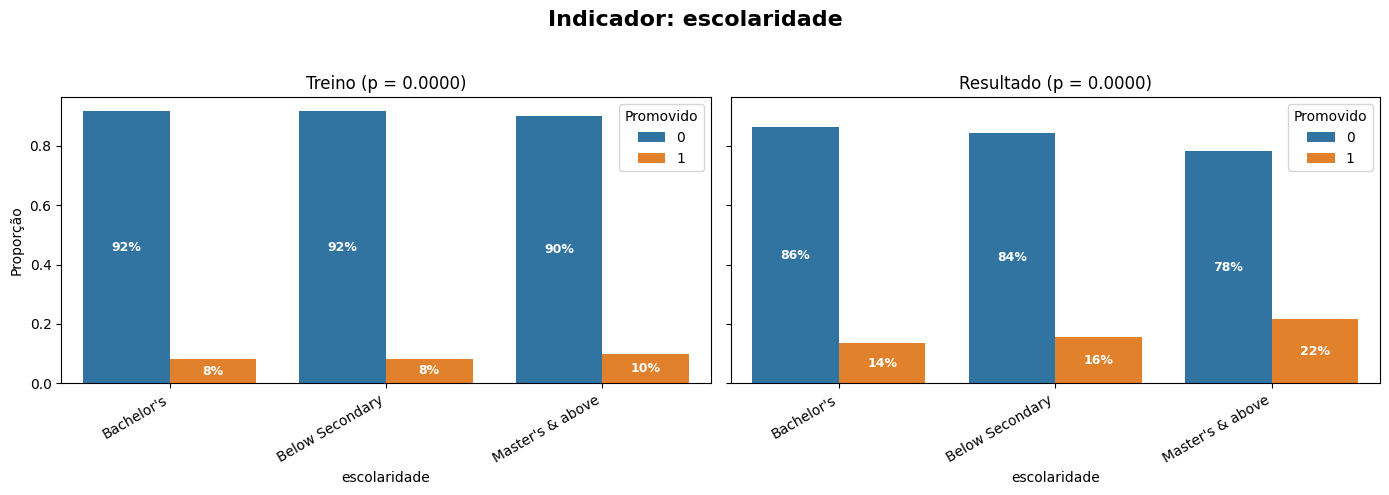


===== Analisando: GENERO =====

--- Análise: genero (Treino) ---
Crosstab (Frequência Absoluta):
promovido      0     1
genero                
f          14845  1467
m          35295  3201

Proporção por categoria:
promovido      0      1
genero                 
f         0.9101 0.0899
m         0.9168 0.0832

📊 Teste Qui-Quadrado:
Chi2 = 6.6773, p-value = 0.0098, DOF = 1
🚨 Diferença significativa detectada nas distribuições!

--- Análise: genero (Resultado) ---
Crosstab (Frequência Absoluta):
promovido      0     1
genero                
f           5745  1149
m          14013  2583

Proporção por categoria:
promovido      0      1
genero                 
f         0.8333 0.1667
m         0.8444 0.1556

📊 Teste Qui-Quadrado:
Chi2 = 4.3496, p-value = 0.0370, DOF = 1
🚨 Diferença significativa detectada nas distribuições!


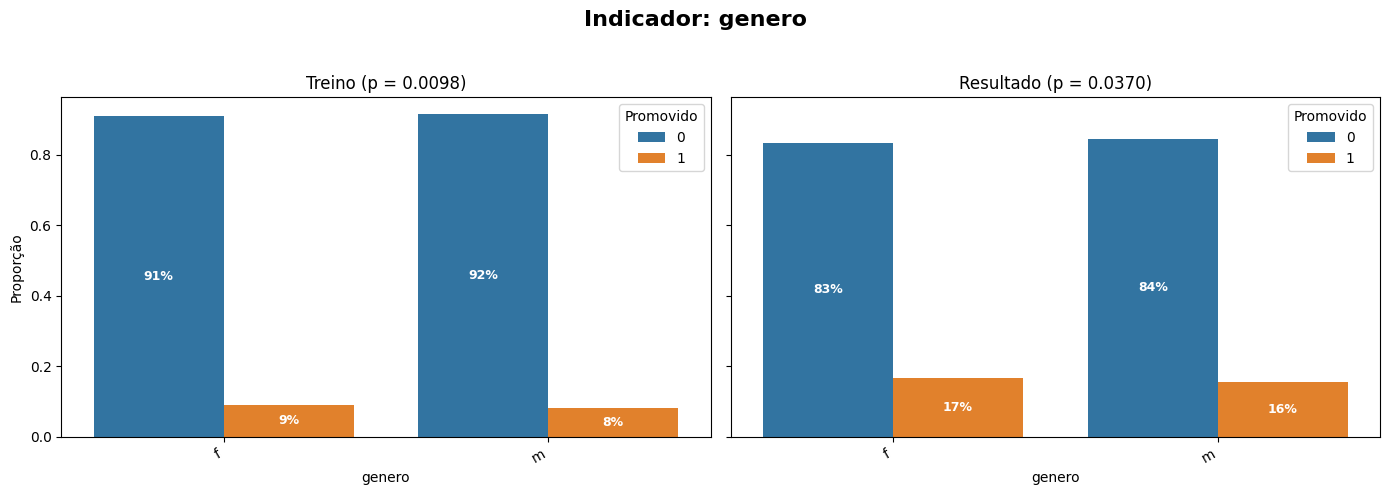


===== Analisando: KPIS_ATINGIDOS =====

--- Análise: kpis_atingidos (Treino) ---
Crosstab (Frequência Absoluta):
promovido           0     1
kpis_atingidos             
0               34111  1406
1               16029  3262

Proporção por categoria:
promovido           0      1
kpis_atingidos              
0              0.9604 0.0396
1              0.8309 0.1691

📊 Teste Qui-Quadrado:
Chi2 = 2689.3221, p-value = 0.0000, DOF = 1
🚨 Diferença significativa detectada nas distribuições!

--- Análise: kpis_atingidos (Resultado) ---
Crosstab (Frequência Absoluta):
promovido           0     1
kpis_atingidos             
0               14699   362
1                5059  3370

Proporção por categoria:
promovido           0      1
kpis_atingidos              
0              0.9760 0.0240
1              0.6002 0.3998

📊 Teste Qui-Quadrado:
Chi2 = 5707.8060, p-value = 0.0000, DOF = 1
🚨 Diferença significativa detectada nas distribuições!


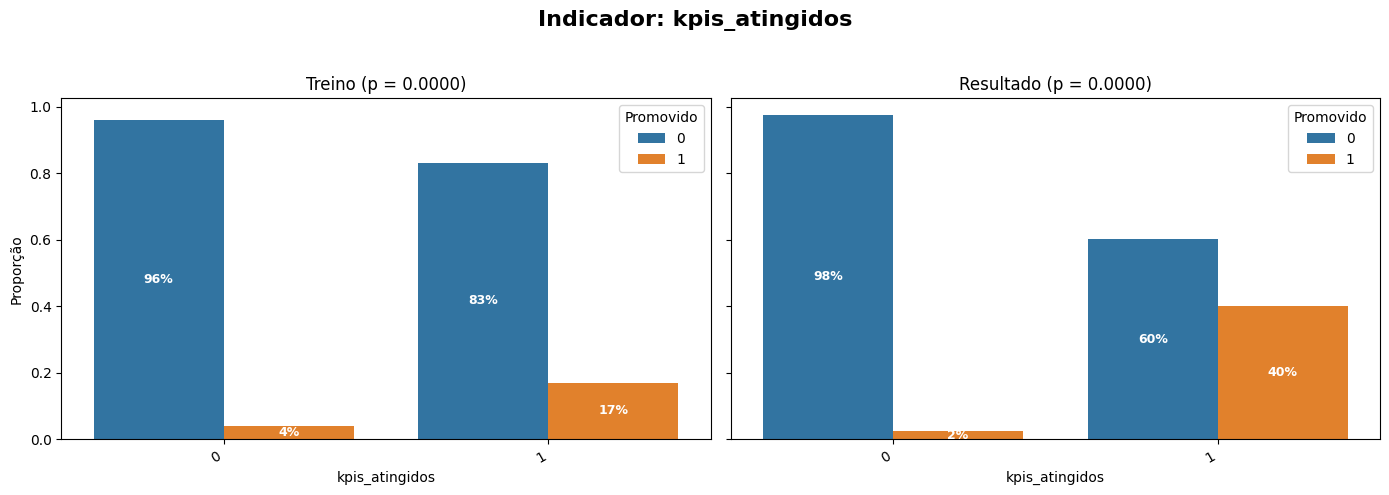


===== Analisando: PREMIOS =====

--- Análise: premios (Treino) ---
Crosstab (Frequência Absoluta):
promovido      0     1
premios               
0          49429  4109
1            711   559

Proporção por categoria:
promovido      0      1
premios                
0         0.9233 0.0767
1         0.5598 0.4402

📊 Teste Qui-Quadrado:
Chi2 = 2098.0719, p-value = 0.0000, DOF = 1
🚨 Diferença significativa detectada nas distribuições!

--- Análise: premios (Resultado) ---
Crosstab (Frequência Absoluta):
promovido      0     1
premios               
0          19637  3318
1            121   414

Proporção por categoria:
promovido      0      1
premios                
0         0.8555 0.1445
1         0.2262 0.7738

📊 Teste Qui-Quadrado:
Chi2 = 1544.5696, p-value = 0.0000, DOF = 1
🚨 Diferença significativa detectada nas distribuições!


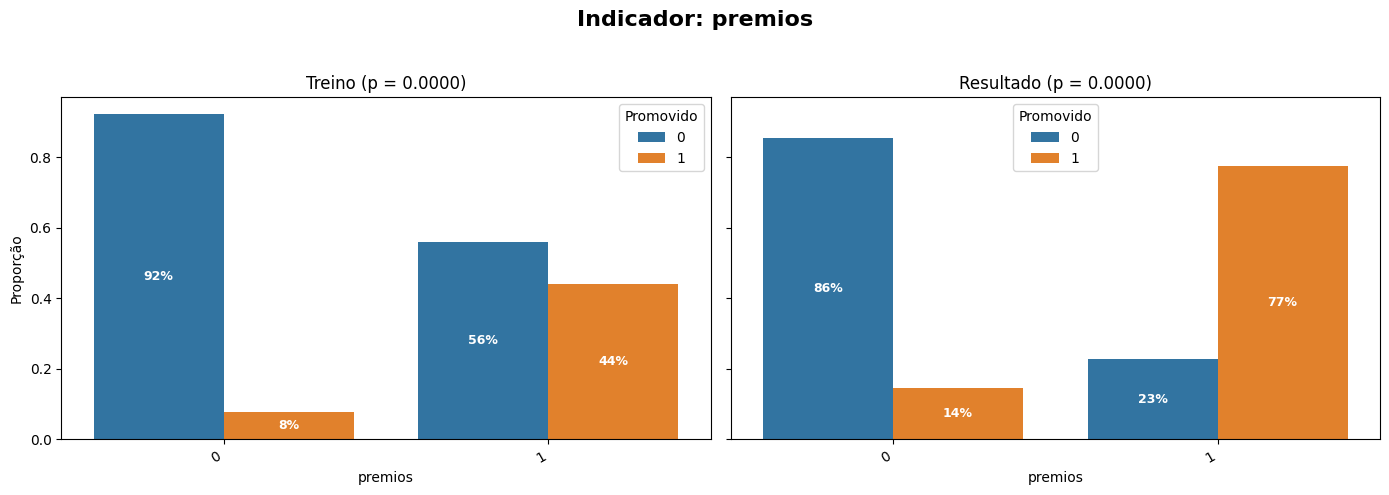

In [37]:
'''Lista de indicadores categóricos'''
indicadores = ['escolaridade', 'genero', 'kpis_atingidos', 'premios']

resultados_finais = {}
for indicador in indicadores:
    print(f'\n===== Analisando: {indicador.upper()} =====')
    resultados_finais[indicador] = analisar_indicador_completo(df_treino, df_resultado, indicador)

## **Análise da Distribuição e Relações entre Variáveis nos Conjuntos de Treinamento e Escoragem**

Para avaliar a consistência e generalização do modelo Random Forest aplicado, realizei uma comparação entre o conjunto de treinamento e o conjunto de escoragem (dados novos, não utilizados durante o treinamento).

**Distribuição da variável alvo (Promoção):**
- Treinamento: 91% não promovidos e 9% promovidos;
- Escoragem: 85% não promovidos e 15% promovidos.

Essa diferença sugere uma leve variação na proporção de promovidos entre os conjuntos, mas ainda dentro de uma faixa razoável para generalização do modelo.

**Análise de associação entre variáveis (Teste Qui-Quadrado):**

Foi utilizado o teste de independência qui-quadrado para verificar a associação entre a variável alvo (Promoção) e variáveis categóricas relevantes. Os resultados, para ambos os conjuntos, foram consistentes:

- **Conjunto de Treinamento:**
    - ***Promoção x Escolaridade:*** Diferença significativa nas distribuições, rejeitando a hipótese nula. Indica que escolaridade influencia a chance de promoção.
    - ***Promoção x Gênero:*** Diferença significativa, indicando influência do gênero na decisão de promoção.
    - ***Promoção x KPI's atingidos:*** Associação significativa, sugerindo que o desempenho medido por KPIs impacta diretamente nas promoções.
    - ***Promoção x Prêmios recebidos:*** Rejeição da hipótese nula, demonstrando que o recebimento de prêmios no ano anterior tem relação com a promoção.
- **Conjunto de Escoragem:**
    - ***Promoção x Escolaridade:*** Mesmo padrão de associação observado no treinamento.
    - ***Promoção x Gênero:*** Diferença estatística significativa mantida, reforçando a influência do gênero na previsão de promoção.
    - ***Promoção x KPI's atingidos:*** Associação significativa consistente com os dados de treino.
    - ***Promoção x Prêmios recebidos:*** Influência também confirmada neste conjunto.

Esses resultados indicam que o modelo está capturando relações consistentes entre variáveis relevantes e a variável alvo. Além disso, a coerência nos padrões entre os dados de treinamento e escoragem sugere uma boa capacidade de generalização.